## Intrusive Galerkin Method / Spectral Projection

When talking about polynomial chaos expansions, there are typically two categories methods that are used: non-intrusive and intrusive methods.
The distinction between the two categories lies in how one tries to solve the problem at hand.
In the intrusive methods, the core problem formulation, often in the form of some governing equations to solve is reformulated to target a polynomial chaos expansion.
In the case of the non-intrusive methods a solver for deterministic case is used in combination of some form of collocation method to fit to the expansion.

The ``chaospy`` toolbox caters for the most part to the non-intrusive methods.
However it is still possible to use the toolbox to solve intrusive formulation.
It just requires that the user to do more of the mathematics them selves.

In [1]:
import chaospy
import numpy
import matplotlib.pyplot as plt

### Problem formulation

Consider the following problem that we will solve using intrusive Galerkin
method:

$$
   \frac{d}{dt} u(t) = -a\ u(t) \qquad u(0) = I \qquad t \in [0, 10]
$$

Here $a$ and $I$ are unknown hyper parameters which can be described through a probability distribution.
For example:

In [2]:
distribution_a = chaospy.Uniform(0.1, 0.2)
distribution_I = chaospy.Uniform(1, 2)
distribution = chaospy.J(distribution_a, distribution_I)
distribution

J(Uniform(lower=0.1, upper=0.2), Uniform(lower=1, upper=2))

First step of intrusive Galerkin's method, we will first assume that the solution $u(t)$ can be expressed as the sum:

$$
   u(t) = \sum_{n=0}^N c_n(t)\ \Phi_n(a, I)
$$

Here $\Phi_n$ are orthogonal polynomials and $c_n$ Fourier coefficients.
We do not know what the latter is yet, but the former we can construct from distribution alone.

In [3]:
polynomial_order = 3
polynomial_expansion = chaospy.orth_ttr(polynomial_order, distribution)
polynomial_expansion[:4].round(10)

polynomial([1.0, -1.5+q1, -0.15+q0, 2.1666666667-3.0*q1+q1**2])

the second step of the method is to fill in the assumed solution into the equations we are trying to solve the following two equations:

$$
   \frac{d}{dt} \sum_{n=0}^N c_n\ \Phi_n = -a \sum_{n=0}^N c_n \qquad
   \sum_{n=0}^N c_n(0)\ \Phi_n = I
$$

The third step is to take the inner product of each side of both equations against the polynomial $\Phi_k$ for $k=0,\cdots,N$.
For the first equation, this will have the following form:

$$
   \left\langle \frac{d}{dt} \sum_{n=0}^N c_n \Phi_n, \Phi_k \right\rangle =
   \left\langle -a \sum_{n=0}^N c_n\Phi_n, \Phi_k \right\rangle \qquad
   \left\langle \sum_{n=0}^N c_n(0)\ \Phi_n, \Phi_k \right\rangle =
   \left\langle I, \Phi_k \right\rangle \\
$$

Let us define the first equation as the main equation, and the latter as the initial condition equation.

### Reformulating the main equation

We start by simplifying the equation. A lot of collapsing of the sums is possible because of the orthogonality property of the polynomials $\langle \Phi_i, \Phi_j\rangle$ for $i \neq j$.

$$
\begin{align*}
   \left\langle \frac{d}{dt} \sum_{n=0}^N c_n \Phi_n, \Phi_k \right\rangle &=
   \left\langle -a \sum_{n=0}^N c_n\Phi_n, \Phi_k \right\rangle \\
   \sum_{n=0}^N \frac{d}{dt} c_n \left\langle \Phi_n, \Phi_k \right\rangle &=
   -\sum_{n=0}^N c_n \left\langle a\ \Phi_n, \Phi_n \right\rangle \\
      \frac{d}{dt} c_k \left\langle \Phi_k, \Phi_k \right\rangle &=
   -\sum_{n=0}^N c_n \left\langle a\ \Phi_n, \Phi_k \right\rangle \\
   \frac{d}{dt} c_k &=
   -\sum_{n=0}^N c_n
   \frac{
      \left\langle a\ \Phi_n, \Phi_k \right\rangle
   }{
      \left\langle \Phi_k, \Phi_k \right\rangle
   }
\end{align*}
$$

Or equivalent, using probability theory notation:

$$
   \frac{d}{dt} c_k =
   -\sum_{n=0}^N c_n
   \frac{
      \mathbb E\left[ a\ \Phi_n \Phi_k \right]
   }{
      \mathbb E\left[ \Phi_k \Phi_k \right]
   }
$$

This is a set of linear equations.
To solve them in practice, we need to formulate the right-hand-side as a function.
To start we create variables to deal with the fact that $a$ and $I$ are part of the equation.

In [4]:
var_a, var_I = chaospy.variable(2)

Note that the order here is important, as the positions of ``distribution_a`` and ``distribution_I`` have to correspond to the variables ``var_a`` and ``var_I`` positional wise.

From the simplified equation above, it can be observed that the fraction of expected values doesn't depend on neither $c$ nor $t$, and can therefore be precomputed.

For the denominator $\mathbb E[a\Phi_n\Phi_k]$, since there are both $\Phi_k$ and $\Phi_n$ terms, the full expression can be defined as a two-dimensional tensor:

In [5]:
phi_outer = chaospy.outer(polynomial_expansion, polynomial_expansion)
[polynomial_expansion.shape, phi_outer.shape]

[(10,), (10, 10)]

This allows us to calculate the full expression:

In [6]:
expected_app = chaospy.E(var_a*phi_outer, distribution)
expected_app[:3, :3]

array([[1.50000000e-01, 0.00000000e+00, 8.33333333e-04],
       [0.00000000e+00, 1.25000000e-02, 0.00000000e+00],
       [8.33333333e-04, 0.00000000e+00, 1.25000000e-04]])

For the numerator $\mathbb E[\Phi_k\Phi_k]$, it is worth noting that these are the square of the norms $\|\Phi_k\|^2$.
We could calculate them the same way, but choose not to.
Calculating the norms is often numerically unstable, and it is better to retrieve them from three-terms-recursion process.
In ``chaospy`` this can be extracted during the creation of the orthogonal polynomials:

In [7]:
_, norms = chaospy.orth_ttr(polynomial_order, distribution, retall=True)
norms[:4]

array([1.00000000e+00, 8.33333333e-02, 8.33333333e-04, 5.55555556e-03])

Having all terms in place, we can create a function for the right-hand-side of the equation:

In [8]:
def right_hand_side(c, t):
    return -numpy.sum(c*expected_app, -1)/norms

### Reformulating the initial conditions


The equation associated with the initial condition can be reformulated as follows:

$$
\begin{align*}
   \left\langle \sum_{n=0}^N c_n(0)\ \Phi_n, \Phi_k \right\rangle &=
   \left\langle I, \Phi_k \right\rangle \\
   \sum_{n=0}^N c_n(0) \left\langle \Phi_n, \Phi_k \right\rangle &=
   \left\langle I, \Phi_k \right\rangle \\
   c_k(0) \left\langle \Phi_k, \Phi_k \right\rangle &=
   \left\langle I, \Phi_k \right\rangle \\
   c_k(0) &=
   \frac{
      \left\langle I, \Phi_k \right\rangle
   }{
      \left\langle \Phi_k, \Phi_k \right\rangle
   }
\end{align*}
$$

Or equivalently:

$$
   c_k(0) =
   \frac{
      \mathbb E\left[ I\ \Phi_k \right]
   }{
      \mathbb E\left[ \Phi_k \Phi_k \right]
   }
$$

Using the same logic as for the first equation we get:

In [9]:
expected_Ip = chaospy.E(var_I*polynomial_expansion, distribution)
initial_condition = expected_Ip / norms

### Solving the set of differential equations

With the right-hand-side for both the main set of equations and the initial conditions, it should be straight forward to solve the equations numerically. For example using the function ``odeint``:

In [10]:
from scipy.integrate import odeint
coordinates = numpy.linspace(0, 10, 1000)
coefficients = odeint(func=right_hand_side, y0=initial_condition, t=coordinates)
coefficients.shape

(1000, 10)

These coefficients can then be used to construct the approximation for $u$ using the assumption about the solutions form:

In [11]:
u_approx = chaospy.sum(polynomial_expansion*coefficients, -1)
u_approx[:4].round(2)

polynomial([q1, q1-0.01*q0*q1, q1-0.02*q0*q1, q1-0.03*q0*q1])

Finally, this can be used to calculate statistical properties:

(array([1.5       , 1.4977495 , 1.4955025 , 1.493259  , 1.49101899]),
 array([0.08333333, 0.08308366, 0.08283514, 0.08258775, 0.08234151]))

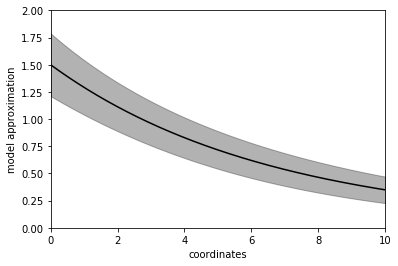

In [12]:
mean = chaospy.E(u_approx, distribution)
variance = chaospy.Var(u_approx, distribution)

plt.xlabel("coordinates")
plt.ylabel("model approximation")
plt.axis([0, 10, 0, 2])
plt.fill_between(coordinates, mean-variance**0.5, mean+variance**0.5, color="k", alpha=0.3)
plt.plot(coordinates, mean, "k-")

mean[:5], variance[:5]